In [1]:
# Importing the libraries 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt #visualisation
%matplotlib inline
sns.set(color_codes=True) 
# Load the libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import missingno as msno
import re
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')


from scipy.stats.mstats import winsorize
import scipy.stats as stats
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)

from statsmodels.tools.eval_measures import mse, rmse
from sklearn import preprocessing

import statsmodels.api as sm
import itertools


On this page, you will find the monthly weighted average prices data for farm-gate raw milk (at real fat and protein content) in Ireland, published by the European Commission (Milk Market Observatory).

The prices collected over the last four years are listed in the table.


На этой странице вы найдете ежемесячные данные о средневзвешенных ценах на сырое молоко с фермы (с реальным содержанием жира и белка) в Ирландии, опубликованные Европейской комиссией (Обсерватория молочного рынка).

Цены, собранные за последние четыре года, перечислены в таблице.

https://www.clal.it/en/index.php?section=latte_mmo&country=IE

In [2]:
df = pd.read_excel('milk.xlsx')
# looking at the dataset
df.head(12)

,Survey Date,2019 Year,2020 Year,2021 Year,2022 Year
0,January,34.28,34.67,35.64,46.03
1,February,34.38,34.86,37.20,47.59
2,March,32.63,31.66,37.10,48.95
3,April,31.66,30.01,36.61,51.28
4,May,31.47,30.59,37.49,53.61
5,June,31.95,31.76,37.39,55.45
6,July,31.08,32.83,37.20,57.78
7,August,31.95,33.89,39.23,59.73
8,September,34.48,36.61,42.44,64.29
9,October,36.61,39.14,46.52,68.47


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survey Date  12 non-null     object 
 1   2019 Year    12 non-null     float64
 2   2020 Year    12 non-null     float64
 3   2021 Year    12 non-null     float64
 4   2022 Year    12 non-null     float64
dtypes: float64(4), object(1)
memory usage: 608.0+ bytes


# Descriptive Statistics  описательная статистика

In [4]:
df.describe()

,2019 Year,2020 Year,2021 Year,2022 Year
count,12.000000,12.00000,12.000000,12.000000
mean,33.691667,34.38750,40.327500,57.640000
std,2.215314,3.17147,4.879156,8.572051
min,31.080000,30.01000,35.640000,46.030000
25%,31.877500,31.73500,37.175000,50.697500
50%,33.455000,34.28000,37.440000,56.615000
75%,34.990000,36.83000,43.460000,65.335000
max,37.290000,39.14000,48.650000,69.250000


Среднее значение mean и медиана 50% цены в 2021 году - 40.33 и 37.44
Легко заметить, что средняя цена в 2022 выросла на 42% по сравнению с 2021 годом. И на 71% по сравнению с 2019 годом.

In [5]:
# set index for Date column

#df.set_index('Survey Date', inplace=True)
#df.index.name = 'Survey Date'

#df1.head()

<AxesSubplot:>

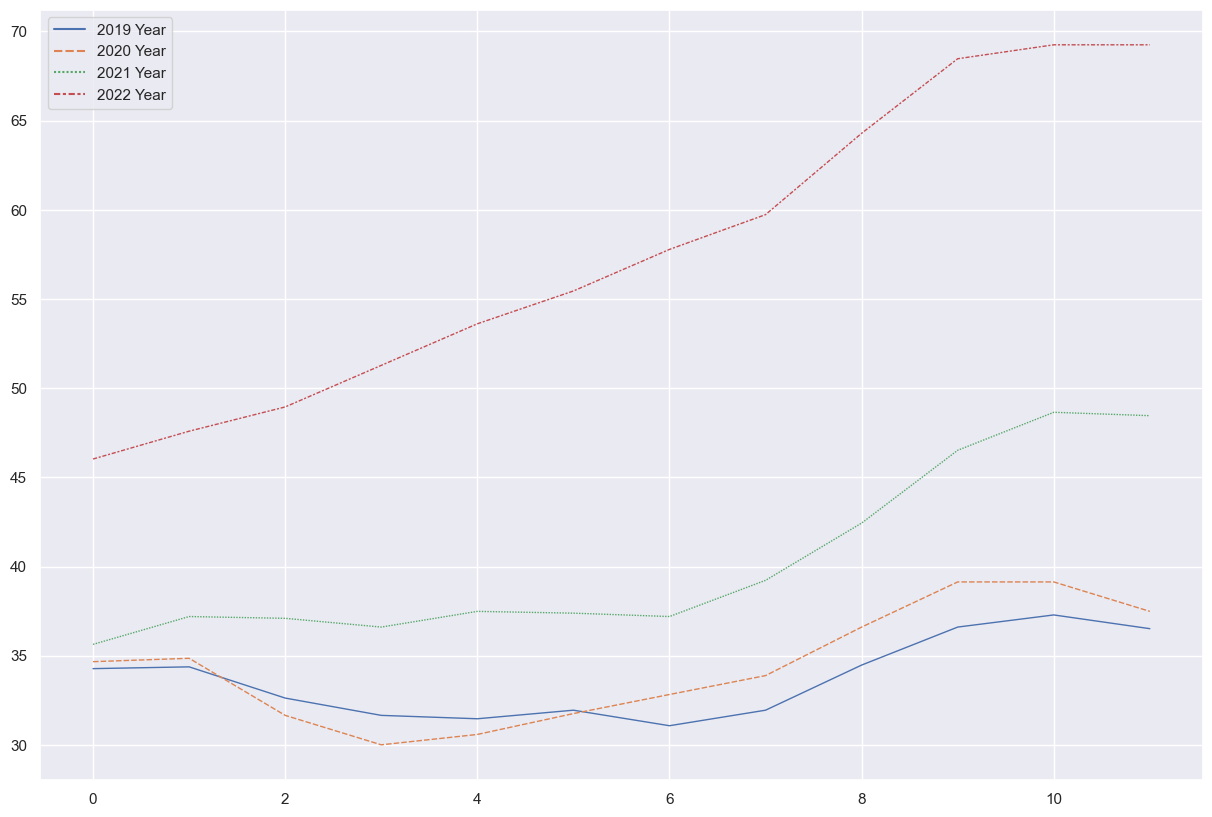

In [6]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df, estimator=None, lw=1)

# На графиках визаульно заметно, как сильно изменились цены на молоко в 2022


Проверка на нормальность в SCIPY
В основе проверки на “нормальность” лежит проверка гипотез. Нулевая гипотеза – данные распределены нормально, альтернативная гипотеза – данные не имеют нормального распределения.¶

In [7]:
import scipy
from scipy import stats

stat, p = scipy.stats.shapiro(df['2022 Year']) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=0.915, p-value=0.248
Принять гипотезу о нормальности


In [8]:
# Shapiro Normal Test
from scipy import stats
import scipy.stats as scs

scs.shapiro(df['2022 Year'])

#Принять гипотезу о нормальности

ShapiroResult(statistic=0.9150821566581726, pvalue=0.2477443516254425)

Второй тест по критерию согласия Пирсона, который тоже возвращает соответствующее значение статистики и p-значение:

In [9]:
stat, p = scipy.stats.normaltest(df['2022 Year']) # Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принять гипотезу о нормальности')
else:
    print('Отклонить гипотезу о нормальности')

Statistics=2.563, p-value=0.278
Принять гипотезу о нормальности


Оценка уровня статистической значимости T-тест (или тест Стьюдента) решает задачу доказательства наличия различий средних значений количественной переменной в случае, когда имеются лишь две сравниваемые группы. Модуль stats Python-библиотеки scipy также предоставляет t-тест. Стоит заметить, проводить t-тест стоит только в случае нормального распределения анализируемых данных. Для экономии времени и места мы опустим эту часть. Здесь имеется функция ttest_ind, вычисляющую t-тест двух независимых выборок. Для зависимых выборок используется функция ttest_rel. Рассмотрим атрибут Length (длина моллюска). Разделим генеральную совокупность на две выборки и определим гипотезы. Нулевая гипотеза – средние двух выборок равны, альтернативная гипотеза – средние двух выборок не равны. Проведем тестирование:

In [10]:
# convert float64 in "2022 Year" col to int.
df['2022 Year'] = df['2022 Year'].astype(int)  

In [11]:
half = len(df['2022 Year']) / 2
sam1 = df.loc[:half, '2022 Year']
sam2 = df.loc[half:, '2022 Year']
scipy.stats.ttest_ind(sam2, sam1)

Ttest_indResult(statistic=5.074692932700854, pvalue=0.00035794337674861787)

Как видим, p-значение меньше 0.05, что говорит о верности нулевой гипотезы. Данные распределен нормально. Кроме того, необходимо проверить, не превышает ли вычисленная t-статистика табличную. Для этого в качестве доверительного интервала выберем 95%. В модуле stats можно посмотреть табличное значение благодаря функции t.ppf. Она принимает в качестве аргументов соответствующие квартили (с доверительным интервалом 95% они будет равняться 0.975 или 0.025, так как это двусторонний тест) и суммарную степень свободы – сумма степеней свободы выборок.

In [12]:
dfs = (half - 1) + (half - 1)
scipy.stats.t.ppf(0.975, dfs)

2.2281388519649385

???????? что не превышает вычисленное значение t-статистики — 5.075. Это означает, что мы не можем отвергнуть нулевую гипотезу. Отсюда заключаем: средние двух выборок равны при условии их нормального распределения.

Доверительный интервал — это диапазон чисел, который охватывает истинное среднее значение данных.

Например: если мой доверительный интервал находится между 53,28 и 62,05 с достоверностью 95%, это действительно означает, что в 95% случаев, когда я выбираю число из этого набора данных, оно будет между 53,28 и 62,05.

In [13]:
import scipy.stats as st
st.norm.interval(alpha=0.95, loc=np.mean(df['2022 Year']), scale=st.sem(df['2022 Year']))

(52.28262047811188, 62.05071285522145)

In [14]:
import scipy.stats as scs
# Calculate the standard error of the mean
error = scs.sem(df['2022 Year'])
# Calculate the confidence interval
scs.norm.interval(alpha=0.95, loc=df['2022 Year'].mean(), scale=error)

(52.28262047811188, 62.05071285522145)

# Временные ряды

In [15]:
df1 = pd.read_excel('milk_2022.xlsx')
# looking at the dataset
df1.head(12)

,Data,Price
0,2021-01-01,35.64
1,2021-02-01,37.20
2,2021-03-01,37.10
3,2021-04-01,36.61
4,2021-05-01,37.49
5,2021-06-01,37.39
6,2021-07-01,37.20
7,2021-08-01,39.23
8,2021-09-01,42.44
9,2021-10-01,46.52


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    24 non-null     datetime64[ns]
 1   Price   24 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 512.0 bytes


In [17]:
# set index for year column
df1.set_index('Data', inplace=True)
df1.index.name = 'Data'

df1.head()

,Price
Data,
2021-01-01,35.64
2021-02-01,37.20
2021-03-01,37.10
2021-04-01,36.61
2021-05-01,37.49


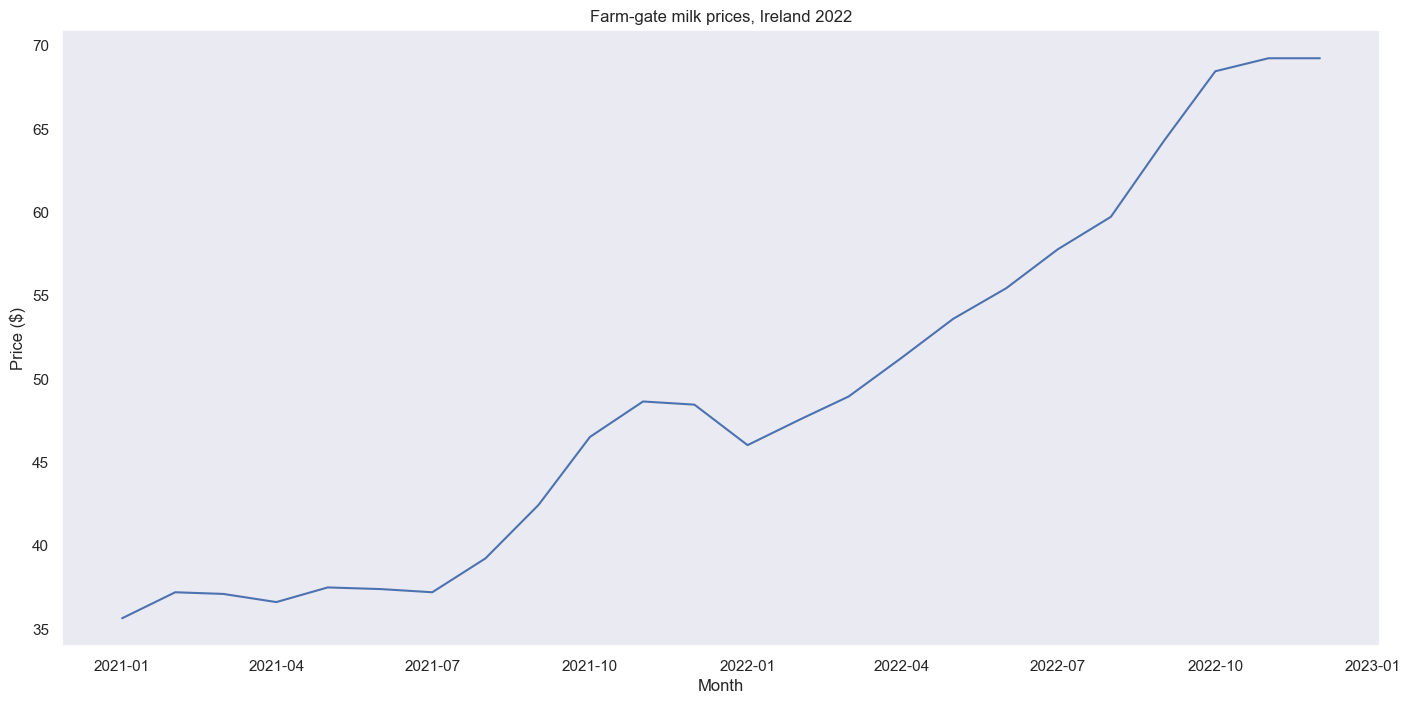

In [18]:
plt.figure(figsize=(17, 8))
plt.plot(df1.Price)
plt.title('Farm-gate milk prices, Ireland 2022')
plt.ylabel('Price ($)')
plt.xlabel('Month')
plt.grid(False)
plt.show()

# Ясно, вы видите, что это не стационарный процесс, и трудно сказать, есть ли какая-то сезонность .


Введите временной ряд . Временной ряд — это просто ряд точек данных, упорядоченных во времени. Во временном ряду время часто является независимой переменной, и цель обычно состоит в том, чтобы сделать прогноз на будущее.

Однако есть и другие аспекты, которые вступают в игру при работе с временными рядами.

Он стационарный ?

Есть ли сезонность ?

Является ли целевая переменная автокоррелированной ?

Мы также можем визуализировать наши данные, используя метод, называемый декомпозицией временных рядов, который позволяет нам разложить наши временные ряды на три отдельных компонента: тренд, сезонность и шум.

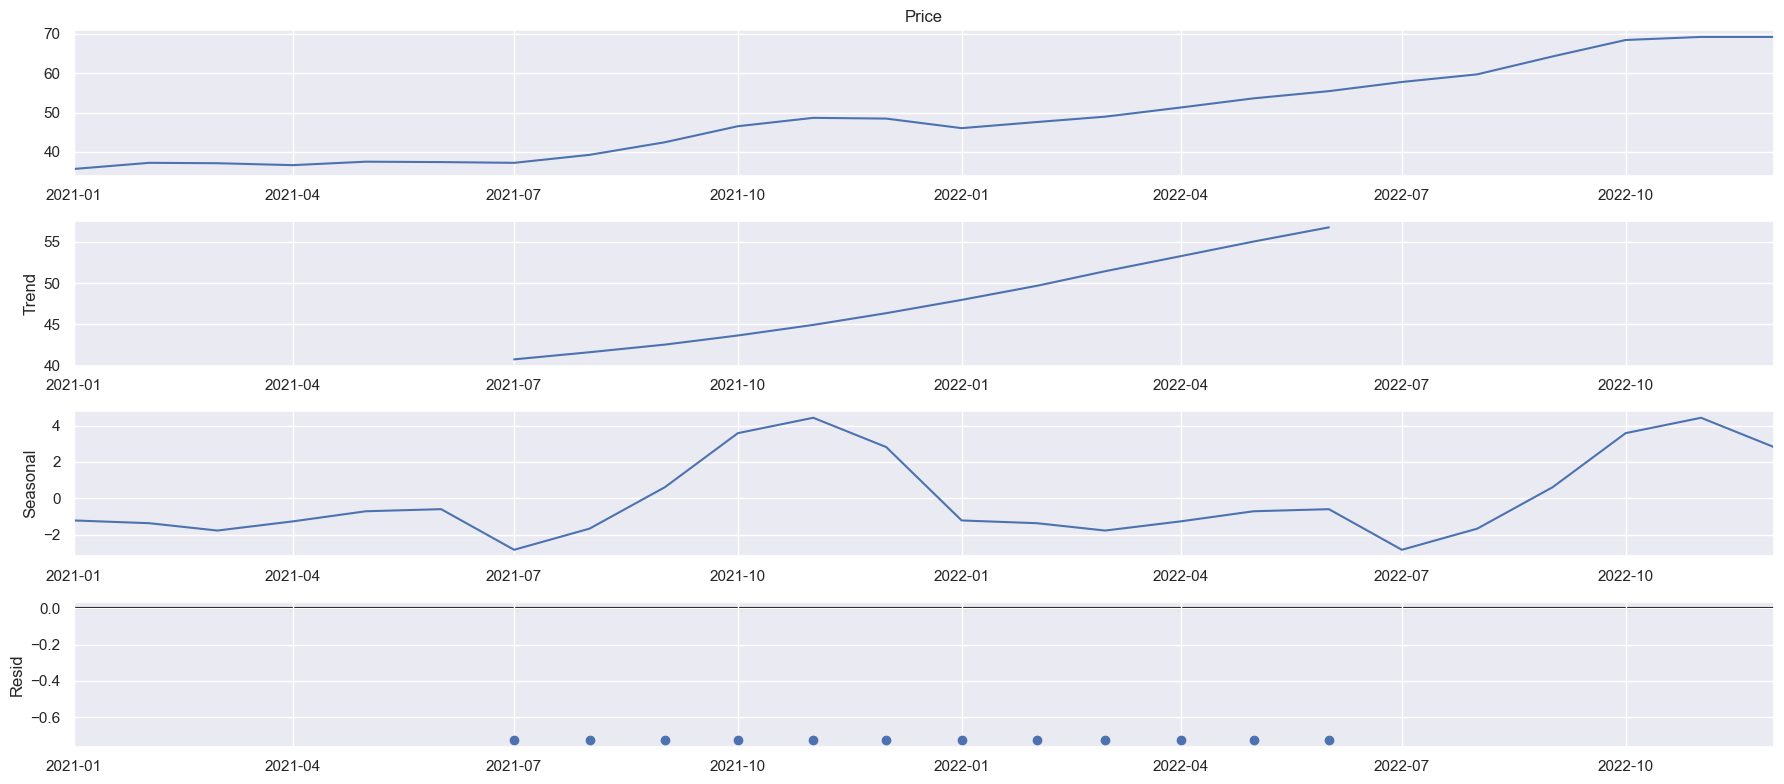

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df1['Price'], model='additive')
fig = decomposition.plot()
plt.show()

## Прогнозирование временных рядов с помощью ARIMA
Мы собираемся применить один из наиболее часто используемых методов прогнозирования временных рядов, известный как ARIMA, что означает авторегрессионное интегрированное скользящее среднее.

Модели ARIMA обозначаются символом ARIMA(p, d, q). Эти три параметра учитывают сезонность, тенденцию и шум в данных:

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df1['Price'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12278D+00    |proj g|=  4.11553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   9.108D-06   5.123D+00
  F =   5.1226704542077206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:247.88818180197057
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl


At iterate    5    f=  2.11235D+00    |proj g|=  1.13107D-01

At iterate   10    f=  2.07780D+00    |proj g|=  9.04222D-04

At iterate   15    f=  2.07759D+00    |proj g|=  5.62907D-04

At iterate   20    f=  2.07752D+00    |proj g|=  3.13122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     36      1     0     0   7.402D-06   2.078D+00
  F =   2.0775194827190511     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:105.72093517051445
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly 

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/o

ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:42.46867926934236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36512D-01    |proj g|=  1.25117D-01

At iterate    5    f=  6.37267D-01    |proj g|=  4.24125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   4.714D-06   6.373D-01
  F =  0.63726690287644061     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:38.58881133806915
RUNNING THE L-BFGS-B C

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequenc

ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:41.20382254260158
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/o


At iterate   10    f=  6.13893D-01    |proj g|=  4.32329D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     28      1     0     0   4.323D-04   6.139D-01
  F =  0.61389263853734011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:39.46684664979232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/o

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62562D+00    |proj g|=  3.46373D-02

At iterate    5    f=  1.62447D+00    |proj g|=  1.29452D-05
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:83.97447862091968

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.275D-06   1.624D+00
  F =   1.6244683046024935     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/o

In [23]:
mod = sm.tsa.statespace.SARIMAX(df1['Price'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09980D-01    |proj g|=  4.39879D-01

At iterate    5    f=  7.47117D-01    |proj g|=  5.28193D-02

At iterate   10    f=  7.40148D-01    |proj g|=  4.74881D-03

At iterate   15    f=  7.37316D-01    |proj g|=  3.60926D-02

At iterate   20    f=  7.35721D-01    |proj g|=  2.84109D-02

At iterate   25    f=  7.34030D-01    |proj g|=  1.50799D-02

At iterate   30    f=  7.33534D-01    |proj g|=  2.42167D-02

At iterate   35    f=  7.33045D-01    |proj g|=  1.88534D-02

At iterate   40    f=  7.32744D-01    |proj g|=  2.47799D-02

At iterate   45    f=  7.32573D-01    |proj g|=  1.99128D-02

At iterate   50    f=  7.32463D-01    |proj g|=  2.57470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/alyona_dushkina/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
results.plot_diagnostics(figsize=(7, 10))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 700x1000 with 0 Axes>

In [ ]:
df_ireland = pd.read_csv('df_ireland_drop.csv')
# looking at the dataset
df_ireland.hea

In [ ]:
df_ireland['Domain'].value_counts()

In [ ]:
df_ireland['Flag Description'].value_counts()

# Официальные данные 4020, Оценочная стоимость 3157, Условно рассчитанная величина 1520, Неофициальная цифра 484

In [ ]:
df_ireland=df_ireland.drop(columns=['Element','Item','Unit','Unnamed: 0','Domain Code','Domain','Year Code','Area Code (M49)','Area','Element Code','Item Code (CPC)','Flag'])
df_ireland.head()

In [ ]:
df_ireland = pd.get_dummies(df_ireland, columns = ['Flag Description'], prefix = 'Flag', drop_first=False)
df_ireland.head()

In [ ]:
df_ireland = df_ireland.query("Year==2020")
df_ireland.head()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_features = df_ireland.copy()
col_names = ['Year', 'Value']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features
df_ireland = scaled_features
df_ireland.head()

In [ ]:
df_ireland.info()

## Dealing with an unbalanced data set

In [ ]:
df_ireland['Flag_Official figure'].value_counts()

In [ ]:
df_ireland['Flag_Official figure'].value_counts().plot.pie(autopct= '%.2f')

In [ ]:
class_1 = df_ireland[df_ireland['Flag_Official figure'] == 1]
class_2  = df_ireland[df_ireland['Flag_Official figure'] == 0]
print(class_1.shape)
print(class_2.shape)

In [ ]:
from sklearn.utils import resample
class_2_downsample = resample(class_2,
             replace=True,
             n_samples=len(class_1),
             random_state=42)

print(class_2_downsample.shape)

In [ ]:
data_downsampled = pd.concat([class_1, class_2_downsample])

In [ ]:
df_ireland = data_downsampled.copy()
df_ireland.reset_index(inplace = True,drop = True)

In [ ]:
df_ireland['Flag_Official figure'].value_counts().plot.pie(autopct= '%.2f')

In [ ]:
df_ireland.info()

## Applying ML Models
NOW THE DATA EXPLORATION, ANALYSIS AND VISUALIZATION AND PREPROCESSING HAS BEEN DONE AND NOW WE CAN MOVE TO MODELLING PART.

In [ ]:
# Spliting the dataset into independent and dependent variables
X = df_ireland.drop(['Flag_Official figure','Year'],axis=1)
y = df_ireland['Flag_Official figure']

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Display the rows and coulmns of X, y, X_train, y_train, X_test, y_test
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# Fitting Naive Bayes Classification to the Training set with linear kernel
from sklearn.naive_bayes import GaussianNB

# Create and initialise an object sc by calling a method GaussianNB()
nvclassifier = GaussianNB()

# Train the model by calling a method fit()
nvclassifier.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred = nvclassifier.predict(X_test)

# Display the predicted values
print(y_pred)

In [ ]:
# Check the actual and predicted value side by side
y_compare = np.vstack((y_test, y_pred)).T
# actual value on the left side and predicted value on the right hand side
# printing the top 10 values
y_compare[:10, :]

In [ ]:
# Construct the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Rounded upto 2 decimal places
print( "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)) )

## Use of Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
nvclassifier = GaussianNB()
cross_val_score(nvclassifier, X, y, scoring='accuracy', cv = 5).mean()

## Creating a K-Nearest Neighbor Classifier


In [ ]:
X = df_ireland.drop(['Flag_Official figure','Year'],axis=1)
y = df_ireland['Flag_Official figure']

from sklearn.model_selection import train_test_split
train_data,test_data,train_label,test_label = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neighbors = np.arange(1, 9)                  # number of neighbors
train_accuracy = np.zeros(len(neighbors))    # Declare and initialise the matrix
test_accuracy = np.zeros(len(neighbors))     # Declare and initialise the matrix

In [ ]:
for i,k in enumerate(neighbors):                          # for loop that checks the model for neighbor values 1, 2, 3, ..., 9
    knn = KNeighborsClassifier(n_neighbors = k)           # Initialise an object knn using KNeighborsClassifier method

    #Fit the model
    knn.fit(train_data, train_label)                      # Call fit method to implement the ML KNeighborsClassifier model

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(train_data, train_label)   # Save the score value in the train_accuracy array

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(test_data, test_label) 

In [ ]:
# Delcare the size of the array
plt.figure(figsize = (10, 6))
plt.title('KNN accuracy with varying number of neighbors', fontsize = 20)
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training accuracy')
plt.legend(prop = {'size': 20})
plt.xlabel('Number of neighbors', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [ ]:
# Declare and initialise an object 'KNeighborsClassifier' with 3 neighbors 
knn = KNeighborsClassifier(n_neighbors = 4)

# Fit the model
knn.fit(train_data, train_label)

# Compute accuracy on the training set
train_accuracy = knn.score(train_data, train_label)

# Compute accuracy on the test set
test_accuracy = knn.score(test_data, test_label)

In [ ]:
# Display the test accuracy
print(test_accuracy)

In [ ]:
from sklearn.model_selection import cross_val_score
nvclassifier = knn
cross_val_score(nvclassifier, X, y, scoring='accuracy', cv = 5).mean()

In [ ]:
# import library for confusion matrix
from sklearn.metrics import confusion_matrix

# Predict the results by calling a method 'predict()'
prediction = knn.predict(test_data)

# Display the confusion matrix
confusion_matrix(test_label, prediction)

In [ ]:
# import the library classification_report
from sklearn.metrics import classification_report

# Display the report
print(classification_report(test_label, prediction))

## Undertake research to find similarities between some country(s) against Ireland, 
and apply parametric and non-parametric inferential statistical techniques to compare them (e.g., t-test, analysis of variance, Wilcoxon test, chi-squared test, among others). 
You must justify your choices and verify the applicability of the tests. Hypotheses and conclusions must be clearly stated. You are expected to use at least 5 different inferential statistics tests.

## ● Провести исследование, чтобы найти сходство между некоторыми странами и Ирландией, 
и применить параметрические и непараметрические статистические методы вывода для их сравнения (например, t-критерий, дисперсионный анализ, критерий Уилкоксона, критерий хи-квадрат и другие). . Вы должны обосновать свой выбор и проверить применимость тестов. Гипотезы и выводы должны быть четко сформулированы. Ожидается, что вы будете использовать как минимум 5 различных тестов логической статистики.

In [ ]:
df_compare = pd.read_excel('milk_compare.xlsx')
df_compare.head(12)


In [ ]:
df_compare = df_compare.dropna()


In [ ]:
df_milk_germany=df_compare.drop(columns=['Ireland','Italy'])
df_milk_germany.head()

In [ ]:
df_milk_italy=df_compare.drop(columns=['Ireland','Germany'])
df_milk_italy.head()

In [ ]:
df_compare.describe()

In [ ]:
df_compare.info()

Сравнивая среднюю цены за 2022 год в Ирландии (57.64), Германии (52.42) и Италии (51.17) мы видим, что в Германии и Италии средняя цена на 9% и 11% соответсвенно меньше, чем в Ирландии. 